In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
gender_submission_df = pd.read_csv('./gender_submission.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing our Training + Test Data

In [4]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
# X_trimmed = train_df.drop(labels=['Name', 'PassengerId', 'Ticket', 'Embarked', 'Cabin'], axis=1)
X_trimmed = train_df.drop(labels=['Name', 'PassengerId', 'Ticket', 'Embarked', 'Cabin', 'SibSp', 'Fare'], axis=1)
survived = train_df['Survived'].copy()
X_trimmed = X_trimmed.drop(labels=['Survived'], axis=1)


X_test_trimmed = test_df.drop(labels=['Name', 'PassengerId', 'Ticket', 'Embarked', 'Cabin', 'SibSp', 'Fare'], axis=1)

In [6]:
print(X_test_trimmed)

     Pclass     Sex   Age  Parch
0         3    male  34.5      0
1         3  female  47.0      0
2         2    male  62.0      0
3         3    male  27.0      0
4         3  female  22.0      1
..      ...     ...   ...    ...
413       3    male   NaN      0
414       1  female  39.0      0
415       3    male  38.5      0
416       3    male   NaN      0
417       3    male   NaN      1

[418 rows x 4 columns]


# Making Some Nice Bar Charts

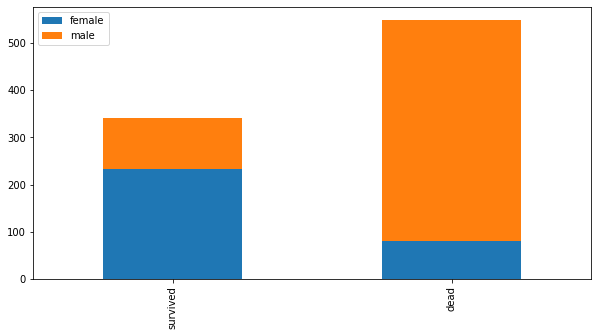

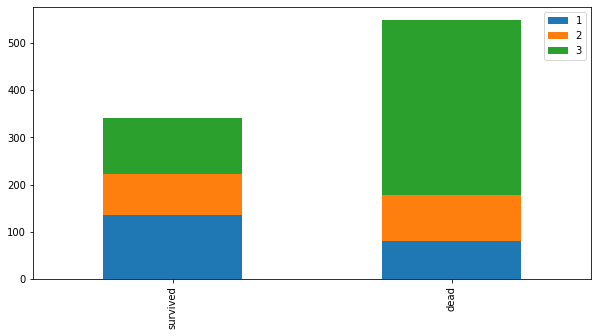

In [7]:
def bar_chart(features):
    survive = train_df[train_df.Survived==1][features].value_counts()
    dead = train_df[train_df.Survived==0][features].value_counts()
    df = pd.DataFrame([survive,dead])
    df.index = ["survived","dead"]
    df.plot(kind="bar",stacked=True,figsize=(10,5))
    
bar_chart("Sex")
bar_chart("Pclass")


# Encoding Gender

In [8]:
from sklearn.preprocessing import LabelEncoder

X_trimmed['Age'] = X_trimmed['Age'].fillna(method='pad')
X_test_trimmed['Age'] = X_test_trimmed['Age'].fillna(method='pad')
# X_test_trimmed['Fare'] = X_test_trimmed['Fare'].fillna(method='pad')

encoder = LabelEncoder()
X_trimmed.iloc[:, 1] = encoder.fit_transform(X_trimmed.iloc[:, 1])
X_test_trimmed.iloc[:, 1] = encoder.fit_transform(X_test_trimmed.iloc[:, 1])

# Check for NANs

In [24]:
print(X_trimmed.isnull().values.any())
print(X_test_trimmed.isnull().values.any())

False
False


# Feature Scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_trimmed_scaled = scaler.fit_transform(X_trimmed)
X_test_trimmed_scaled = scaler.fit_transform(X_test_trimmed)

# Look at our Trimmed Data One Last Time

In [26]:
print(X_trimmed_scaled)

[[1.         1.         0.27117366 0.        ]
 [0.         0.         0.4722292  0.        ]
 [1.         0.         0.32143755 0.        ]
 ...
 [1.         0.         0.23347575 0.33333333]
 [0.         1.         0.32143755 0.        ]
 [1.         1.         0.39683338 0.        ]]


# Predictions

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns

ID = pd.Series(range(892, 1310))

### K Nearest Neighbors


In [91]:
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i, weights='distance')
    knn.fit(X_trimmed_scaled, survived)

    print('Accuracy of K-NN classifier on training set: {:.2f}'
         .format(knn.score(X_trimmed_scaled, survived)))


    knn_predict = knn.predict(X_test_trimmed_scaled)
    y1 = np.array(knn_predict)
    sol = pd.DataFrame({'PassengerId':ID, 'Survived':y1})
    sol.to_csv('Solution_KNN.csv', index=False)

    knn_trained_predict = knn.predict(X_trimmed_scaled)

    cm = confusion_matrix(knn_trained_predict, survived)
    # sns.heatmap(cm, annot=True)
    print(cm)

    print("Model has accuracy percentage of: ")
    print(classification_report(knn_trained_predict, survived))

Accuracy of K-NN classifier on training set: 0.88
[[504  65]
 [ 45 277]]
Model has accuracy percentage of: 
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       569
           1       0.81      0.86      0.83       322

    accuracy                           0.88       891
   macro avg       0.86      0.87      0.87       891
weighted avg       0.88      0.88      0.88       891

Accuracy of K-NN classifier on training set: 0.89
[[547  98]
 [  2 244]]
Model has accuracy percentage of: 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       645
           1       0.71      0.99      0.83       246

    accuracy                           0.89       891
   macro avg       0.85      0.92      0.87       891
weighted avg       0.92      0.89      0.89       891

Accuracy of K-NN classifier on training set: 0.89
[[515  65]
 [ 34 277]]
Model has accuracy percentage of: 
              precisio

### Random Forest

Accuracy of RandomForest on training set: 0.89
Model has accuracy percentage of: 
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       583
           1       0.80      0.89      0.85       308

    accuracy                           0.89       891
   macro avg       0.87      0.89      0.88       891
weighted avg       0.89      0.89      0.89       891



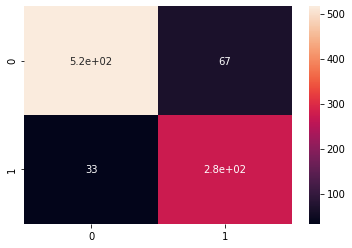

In [55]:
clf = RandomForestClassifier(n_estimators = 500, min_samples_split=5)
clf.fit(X_trimmed_scaled, survived)

print('Accuracy of RandomForest on training set: {:.2f}'
     .format(clf.score(X_trimmed_scaled, survived)))

clf_predict = clf.predict(X_test_trimmed_scaled)
y1 = np.array(clf_predict)
sol = pd.DataFrame({'PassengerId':ID, 'Survived':y1})
sol.to_csv('Solution_CLF.csv', index=False)

clf_trained_predict = clf.predict(X_trimmed_scaled)

cm = confusion_matrix(clf_trained_predict, survived)
sns.heatmap(cm, annot=True)

print("Model has accuracy percentage of: ")
print(classification_report(clf_trained_predict, survived))

# Using Deep Neural Networks to Predict 

In [88]:
ann = tf.keras.models.Sequential()


# Adding the input layer and the 2nd hidden layer
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))

# Adding the input layer and the 1st hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Adding the input layer and the 2nd hidden layer
ann.add(tf.keras.layers.Dense(units=4, activation='linear'))

# Adding the input layer and the third hidden layer
ann.add(tf.keras.layers.Dense(units=2, activation='sigmoid'))

# Adding the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [89]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the ANN on the Training set
ann.fit(X_trimmed_scaled, survived, batch_size=100, epochs=200)

Epoch 1/200
9/9 [==============================] - 0s 887us/step - loss: 0.7412 - accuracy: 0.3838
Epoch 2/200
9/9 [==============================] - 0s 997us/step - loss: 0.7322 - accuracy: 0.3838
Epoch 3/200
9/9 [==============================] - 0s 887us/step - loss: 0.7239 - accuracy: 0.3838
Epoch 4/200
9/9 [==============================] - 0s 740us/step - loss: 0.7168 - accuracy: 0.3838
Epoch 5/200
9/9 [==============================] - 0s 913us/step - loss: 0.7102 - accuracy: 0.3838
Epoch 6/200
9/9 [==============================] - 0s 775us/step - loss: 0.7043 - accuracy: 0.3838
Epoch 7/200
9/9 [==============================] - 0s 970us/step - loss: 0.6987 - accuracy: 0.3838
Epoch 8/200
9/9 [==============================] - 0s 911us/step - loss: 0.6937 - accuracy: 0.3838
Epoch 9/200
9/9 [==============================] - 0s 969us/step - loss: 0.6890 - accuracy: 0.3838
Epoch 10/200
9/9 [==============================] - 0s 670us/step - loss: 0.6849 - accuracy: 0.4456
Epoch 11/

9/9 [==============================] - 0s 665us/step - loss: 0.5430 - accuracy: 0.7946
Epoch 84/200
9/9 [==============================] - 0s 624us/step - loss: 0.5420 - accuracy: 0.7946
Epoch 85/200
9/9 [==============================] - 0s 665us/step - loss: 0.5407 - accuracy: 0.7946
Epoch 86/200
9/9 [==============================] - 0s 665us/step - loss: 0.5395 - accuracy: 0.7946
Epoch 87/200
9/9 [==============================] - 0s 776us/step - loss: 0.5383 - accuracy: 0.7946
Epoch 88/200
9/9 [==============================] - 0s 665us/step - loss: 0.5376 - accuracy: 0.7935
Epoch 89/200
9/9 [==============================] - 0s 554us/step - loss: 0.5362 - accuracy: 0.7957
Epoch 90/200
9/9 [==============================] - 0s 737us/step - loss: 0.5350 - accuracy: 0.7969
Epoch 91/200
9/9 [==============================] - 0s 554us/step - loss: 0.5337 - accuracy: 0.7969
Epoch 92/200
9/9 [==============================] - 0s 776us/step - loss: 0.5328 - accuracy: 0.7957
Epoch 93/200


Epoch 164/200
9/9 [==============================] - 0s 665us/step - loss: 0.4770 - accuracy: 0.8070
Epoch 165/200
9/9 [==============================] - 0s 665us/step - loss: 0.4765 - accuracy: 0.8058
Epoch 166/200
9/9 [==============================] - 0s 665us/step - loss: 0.4761 - accuracy: 0.8103
Epoch 167/200
9/9 [==============================] - 0s 598us/step - loss: 0.4754 - accuracy: 0.8070
Epoch 168/200
9/9 [==============================] - 0s 887us/step - loss: 0.4751 - accuracy: 0.8058
Epoch 169/200
9/9 [==============================] - 0s 799us/step - loss: 0.4749 - accuracy: 0.8058
Epoch 170/200
9/9 [==============================] - 0s 661us/step - loss: 0.4744 - accuracy: 0.8047
Epoch 171/200
9/9 [==============================] - 0s 554us/step - loss: 0.4740 - accuracy: 0.8070
Epoch 172/200
9/9 [==============================] - 0s 589us/step - loss: 0.4732 - accuracy: 0.8103
Epoch 173/200
9/9 [==============================] - 0s 775us/step - loss: 0.4729 - accurac

In [61]:
ann_predict = ann.predict(X_test_trimmed_scaled)
y1 = np.array(ann_predict)
y1 = (y1 > 0.5).flatten() * 1
sol = pd.DataFrame({'PassengerId':ID, 'Survived':y1})
sol.to_csv('Solution_ANN.csv', index=False)

# XG BOOSTING

In [62]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV

params = {"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"max_depth":[1,2,3,4,5,6,8,9,10],"min_child_weight":[1,2,3,4,5,6,7,8,9],"gamma":[0.0,0.1,0.2,0.3,0.4,0.5],"colsample_bytree":[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"n_estimators":[100,200,300,400,500]}
classifier = XGBClassifier()
random_search = RandomizedSearchCV(classifier, param_distributions=params,n_iter=10,scoring="roc_auc",n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_trimmed_scaled, survived)
random_search.best_estimator_    

XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=1, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

XGB_fit = XGB.fit(X_trimmed_scaled, survived)

pred_XGB = XGB.predict(X_test_trimmed_scaled)
train_pred_XGB = XGB.predict(X_trimmed_scaled)

#94%
sol = pd.DataFrame({'PassengerId':ID, 'Survived':pred_XGB})
sol.to_csv('Solution_XGB.csv', index=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  44 out of  50 | elapsed:    7.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished
C:\Users\16472\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
print(confusion_matrix(train_pred_XGB, survived))
print()
print(classification_report(train_pred_XGB, survived))

[[507  76]
 [ 42 266]]

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       583
           1       0.78      0.86      0.82       308

    accuracy                           0.87       891
   macro avg       0.85      0.87      0.86       891
weighted avg       0.87      0.87      0.87       891

